In [1]:
from __future__ import print_function, division
import json 
import numpy
import numpy as np
import cv2
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import time
import os
import copy
import sys

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

import requests
import io

from copy import copy, deepcopy
import collections

In [2]:
class SAVE_IMAGE:
    
    def __init__(self, ncols = 0, nrows = 0, figTitle="", axis = True):
        
        if ncols == 0 or nrows == 0:
            raise ValueError("ncols and nrows must be initialize")
        
        dpi = 80
        height, width, depth = CV2_IMG.shape
        figsize = width / float(dpi) * ncols , height / float(dpi) * nrows
        self.fig, self.ax = plt.subplots(ncols = ncols, nrows = nrows, figsize=figsize)
        self.ncols = ncols
        self.nrows = nrows
        
        if axis is False:
            plt.axis(False)
        
        if figTitle is not "":
            self.fig.suptitle(figTitle, fontsize=20)
        self.ccols = 0
        self.crows = 0
        
    def addImage(self, img, title = ""):
        
        if self.nrows == 1:
            if self.ncols == 1:
                self.ax.imshow(img)
                if title is not "":
                    self.ax.set_title(title, fontsize=15)
            else:
                self.ax[self.ccols].imshow(img)
                if title is not "":
                    self.ax[self.ccols].set_title(title, fontsize=15)
        else:
            self.ax[self.crows][self.ccols].imshow(img)
            if title is not "":
                self.ax[self.crows][self.ccols].set_title(title, fontsize=15)

        if self.ccols+1 == self.ncols:
            self.crows = self.crows + 1
            self.ccols = 0
        else:
            self.ccols = self.ccols + 1
            
    def showImage(self):
        plt.show()
        
    def saveImage(self, save_path, save_title):
        plt.savefig(save_path+save_title+'.png', bbox_inches='tight')

In [3]:
def CheckDirExists(PATH, DIR):
    if not os.path.exists(PATH+DIR):
        os.makedirs(PATH+DIR)

In [4]:
def getHeatmap(img_list, height, width, title = "", figSet = False, fig = [0, 0]):
    _title = "_color_heatmap"
    heatmaps = []
    
    if figSet:
        save_image = SAVE_IMAGE(nrows = fig[0], ncols = fig[1], figTitle=title+_title)
    else: 
        save_image = SAVE_IMAGE(nrows = 1, ncols = len(img_list), figTitle=title+_title)
    
    for index, img in enumerate(img_list):
        heatmap = cv2.applyColorMap(cv2.resize(img, (width, height)), cv2.COLORMAP_JET)
        heatmaps.append(heatmap)
        tmp_img = heatmap*0.6 + CV2_IMG*0.4
        save_image.addImage(cv2.cvtColor(np.float32(tmp_img).astype('uint8'), cv2.COLOR_BGR2RGB))
        
    save_image.saveImage(RESULT_PATH+RESULT_DIR, title+_title)

In [5]:
def pooling(mat,ksize,method='mean',pad=False):
    '''Non-overlapping pooling on 2D or 3D data.

    <mat>: ndarray, input array to pool.
    <ksize>: tuple of 2, kernel size in (ky, kx).
    <method>: str, 'max for max-pooling, 
                   'mean' for mean-pooling.
    <pad>: bool, pad <mat> or not. If no pad, output has size
           n//f, n being <mat> size, f being kernel size.
           if pad, output has size ceil(n/f).

    Return <result>: pooled matrix.
    '''

    m, n = mat.shape[:2]
    ky = ksize
    kx = ksize

    _ceil=lambda x,y: int(numpy.ceil(x/float(y)))

    if pad:
        ny=_ceil(m,ky)
        nx=_ceil(n,kx)
        size=(ny*ky, nx*kx)+mat.shape[2:]
        mat_pad=numpy.full(size,numpy.nan)
        mat_pad[:m,:n,...]=mat
    else:
        ny=m//ky
        nx=n//kx
        mat_pad=mat[:ny*ky, :nx*kx, ...]

    new_shape=(ny,ky,nx,kx)+mat.shape[2:]

    if method=='max':
        result=numpy.nanmax(mat_pad.reshape(new_shape),axis=(1,3))
        #print(result.dtype)
    else:
        result=numpy.nanmean(mat_pad.reshape(new_shape),axis=(1,3)).astype(np.uint8)
        #print(result.shape)
        #print(result)

    return result

In [6]:
def threshold(CAM_result):
    for i in range(0,CAM_result.shape[0]):
        for j in range(0,CAM_result.shape[1]):
            if CAM_result[i][j]>=(224/4)*3:
                CAM_result[i][j] = 225
            elif CAM_result[i][j]>=(224/4)*2:
                CAM_result[i][j] = 160
            elif CAM_result[i][j]>=(224/4)*1:
                CAM_result[i][j] = 80
            else:
                CAM_result[i][j] = 0
    return CAM_result

In [7]:
def featureMAP(feature_conv, feature_index): #feature_index를 받으면
    size_upsample = (224, 224)
    bz, nc,  h, w = feature_conv.shape
    output_cam = []
    cam = feature_conv[0][feature_index]
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [8]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape#(1,2208,7,7)
    #print(feature_conv.shape)
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))#결과값은 (1,49),feature_conv.reshape값은 (2208,49)
        cam = cam.reshape(h, w)#(7,7)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [9]:
def setPretrainedModel(PATH = ""):
    
    if not os.path.isfile(PATH):
        raise ValueError(f"file does not exists in {PATH}")
    
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 20)

    net = model.to(device)
    param = list(net.parameters())

    net.load_state_dict(torch.load(PATH))
    net.eval()

    features_blobs = []
    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())
        
    net._modules.get('layer4').register_forward_hook(hook_feature)

    params = list(net.parameters())
    weight_softmax = np.squeeze(params[-2].cpu().data.numpy())
    
    np.set_printoptions(threshold=sys.maxsize)
    
    return net, features_blobs, weight_softmax

In [10]:
def getImage(IMG_URL = ""):
    response = requests.get(IMG_URL)
    img_pil = Image.open(io.BytesIO(response.content))
    CV2_IMG = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    
    img_tensor = preprocess(img_pil)
    img_variable = Variable(img_tensor.unsqueeze(0))
    
    return img_variable, CV2_IMG

In [11]:
def getFeatureMaps(MODEL_PATH, IMG_URL):
    net, features_blobs, weight_softmax = setPretrainedModel(MODEL_PATH)
    
    img_variable, _ = getImage(IMG_URL)
    img_variable = img_variable.to(device)
    logit = net(img_variable)
    
    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)

    case = features_blobs[0].reshape((2048,49)) #case는 마지막 conv_layer을 GAP 완료한 값이라고 생각

    sum_array = []
    for i in range(0,2048):
        sum_score = 0
        for j in range(0,49):
            sum_score += case[i][j]
        sum_array.append(sum_score)#길이는 2208

    max_array = sorted(sum_array)
    max_array_index = []

    for i in range(1844,2048): 
        max_array_index.append(sum_array.index(max_array[i]))

    max_array_index.reverse()

    FeatureMAP = []

    for i in range(0,204):
        featureCam = []
        featureCam = featureMAP(features_blobs[0], max_array_index[i])
        featureResult = pooling(featureCam[0],ksize = 4)
        threshold_result = threshold(featureResult)
        FeatureMAP.append(threshold_result)
        
    return numpy.array(FeatureMAP)

In [12]:
def getCAMResult(MODEL_PATH, IMG_URL):
    net, features_blobs, weight_softmax = setPretrainedModel(MODEL_PATH)
    
    img_variable, _ = getImage(IMG_URL)
    img_variable = img_variable.to(device)
    logit = net(img_variable)
    
    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    
    feature_index = []

    x = weight_softmax[idx[0]].max() #weight_softmax를 변경하면 결과값이 달라짐
    array = weight_softmax[idx[0]].argsort()

    for i in range(103,1946): #상위 5%+하위 5%를 제외
        t = array[i]
        feature_index.append(t)

    feature_index.reverse()
    new_weight = weight_softmax.copy()

    for i in range(0,20): # 모든 class에 대하여
        for j in range(0,2048):
            if j not in feature_index:
                new_weight[i][j] = 0
           
    CAM_RESULTS = []
    for cls_idx, cls in enumerate(classes):
        CAM = returnCAM(features_blobs[0], weight_softmax, [idx[cls_idx]])
        CAM = pooling(CAM[0],ksize = 4)
        CAM = threshold(CAM)
        
        CAM_RESULTS.append(CAM)
        
    """
    CAMs_bicycle = returnCAM(features_blobs[0], weight_softmax, [idx[0]])
    CAMs_person = returnCAM(features_blobs[0], weight_softmax, [idx[1]])

    np.set_printoptions(threshold=sys.maxsize)

    new_CAM_bicycle = pooling(CAMs_bicycle[0],ksize = 4)
    new_CAM_person = pooling(CAMs_person[0],ksize = 4)

    new_threshold_bicycle = threshold(new_CAM_bicycle)
    new_threshold_person = threshold(new_CAM_person)

    CAM = []
    CAM.append(new_threshold_bicycle)
    CAM.append(new_threshold_person)
    """
    
    return CAM_RESULTS

In [13]:
def calculateGridLevel(CAM, FeatureMap):
    
    # 0: 255, 1:160, 2:80, 3:0
    print(CAM.shape)
    print(FeatureMap.shape)

    # CAM에서 255, 160 부분만 활성화. 나머지는 0
    rows, cols = CAM.shape
    
    result = CAM
    result[result < 160] = 0
    
    for row in range(rows):
        for col in range(cols):
            
            # 빨, 파, 보 skip
            if result[row][col] != threshold_value[1]:
                continue
            
            
            # 노란색인 경우만 계산
            ## fm이 0인 경우
            if FeatureMap[row][col] == threshold_value[3]:
                result[row][col] = threshold_value[3]
            ## fm이 80인 경우
            elif FeatureMap[row][col] == threshold_value[2]:
                result[row][col] = threshold_value[2]
            ## fm이 255인 경우
            elif FeatureMap[row][col] == threshold_value[0]:
                result[row][col] = threshold_value[0]
            
                
    return result

In [14]:
def getGridBoundingBox(FeatureMap, CAM):
    results = []
    
    for cls_idx, cls in enumerate(classes):
        
        results.append(calculateGridLevel(CAM[cls_idx], FeatureMap[cls_idx]))
        
    
    return results

In [15]:
def getAggregatedValue(mode, occurrence_of_values, sorted_keys, min_difference_cnt):
    if mode == 0:
        return int(sorted_keys[0])
    elif mode == 1:
        if sorted_keys[0] == (threshold_value[0] or threshold_value[1]):
                return int(sorted_keys[0])
        else:
            if len(sorted_keys) > 1 and sorted_keys[1] == (threshold_value[0] or threshold_value[1]):
                if occurrence_of_values[sorted_keys[0]] - occurrence_of_values[sorted_keys[1]] >= min_difference_cnt:
                    return int(sorted_keys[1])
            return int(sorted_keys[0])

In [16]:
def makeAggregatedFeatureMap(mode, FeatureMap, CAM):
    
    #print(FeatureMap)
    
    num_of_featuremaps = FeatureMap.shape[0]
    min_difference_cnt = int(num_of_featuremaps / 10)
    
    rows, cols = CAM.shape
    
    result = deepcopy(CAM)
    result[result < 300] = 0
    
    for row in range(rows):
        for col in range(cols):
            
            featuremap_values = FeatureMap[:,row,col]
            occurrence_of_values = collections.Counter(featuremap_values)
            sorted_keys = sorted(occurrence_of_values, key = occurrence_of_values.get, reverse=True)
            
            result[row][col] = getAggregatedValue(mode, occurrence_of_values, sorted_keys, min_difference_cnt)

            #print(featuremap_values)
            #print(result[row][col])
    return result

In [17]:
def makeSegment_ver1(fm_mode, FeatureMap, CAM):
    fm = makeAggregatedFeatureMap(fm_mode, FeatureMap, deepcopy(CAM[0]))

    title = "featuremap"
    getHeatmap([fm], height, width, title = title, figSet = True, fig = [1, 1])
    
    final_grid_threshold = getGridBoundingBox(fm, CAM)
    
    title = "get_final_grid_result"
    getHeatmap(final_grid_threshold, height, width, title = title, figSet = True, fig = [1, len(classes)])

In [18]:
def aggregate_fm_based_on_Iou(FeatureMap, CAM):
    Results = []
    for cam_idx, cam in enumerate(CAM):
        flag = 0
        candidate_featuremaps = []
        getHeatmap([cam], height, width, title = f"class{cam_idx}_original_cam", figSet = True, fig = [1, 1])
        for fm_idx, fm in enumerate(FeatureMap):
            if grid_segments_IoU(cam, fm, height, width):
                #fm[fm < 160] = 0
                if flag < 5:
                    getHeatmap([fm], height, width, title = f"class{cam_idx}_iou_over_{flag}", figSet = True, fig = [1, 1])
                    flag += 1
                candidate_featuremaps.append(numpy.array(fm))
        print(len(candidate_featuremaps))
        Results.append(makeAggregatedFeatureMap(1, numpy.array(candidate_featuremaps), cam))
        
    return numpy.array(Results)

In [19]:
def get_bbox_with_contours(area):
    
    bbox = []
    
    _, area_binary = cv2.threshold(cv2.resize(area, (width, height)), threshold_value[1], 1, cv2.THRESH_BINARY)
    
    contours, hierarchy = cv2.findContours(area_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bb.append({'x1': x, 'y1': y, 'x2': x +w, 'y2': y +h})

In [20]:
def grid_segments_IoU(area1, area2, height, width):
    
    # area1을 0.7 이상 포함하면 true, 아니면 false
    if area1.shape != area2.shape:
        raise ValueError("both area1 and area2 should have same shape")
        
    area1 = cv2.resize(area1, (width, height))
    area2 = cv2.resize(area2, (width, height))
    
    _, area1_binary = cv2.threshold(cv2.resize(area1, (width, height)), threshold_value[1], 1, cv2.THRESH_BINARY)
    _, area2_binary = cv2.threshold(cv2.resize(area2, (width, height)), threshold_value[1], 1, cv2.THRESH_BINARY)
    
    intersection_area = numpy.bitwise_and(area1_binary, area2_binary)
    
    area1_cnt = (area1_binary == 1).sum()
    iou_cnt = (intersection_area == 1).sum()
    
    iou = float(iou_cnt) / area1_cnt
    
    if iou > 0.7:
        return True
    else:
        return False

In [21]:
def makeSegment_ver2(fm_mode, FeatureMap, CAM):
    FeatureMap = deepcopy(FeatureMap)
    CAM = deepcopy(CAM)
    fm = aggregate_fm_based_on_Iou(FeatureMap, CAM)
    
    title = "aggregated_featuremap"
    getHeatmap(fm, height, width, title = title, figSet = True, fig = [1, len(classes)])
    
    final_grid_threshold = getGridBoundingBox(fm, CAM)
    
    title = "final_grid_result"
    getHeatmap(final_grid_threshold, height, width, title = title, figSet = True, fig = [1, len(classes)])

In [22]:
def aggregate_fm_based_on_contours(FeatureMap, CAM):
    
    for cam_idx, cam in enumerate(CAM):
        cam_bbox = get_bbox_with_contours(cam)

In [23]:
def makeSegment_ver3(FeatureMap, CAM):
    
    # Featuremap bbox 구하기
    
    # CAM bbox 구하기
    
    # iou 0.7 이상인 것 골라내기
    
    # 최소-최대 부분만 포함하기 grid로
    # countour로 iou 구하기
    fm = aggregate_fm_based_on_contours(FeatureMap, CAM)
    

In [24]:
classes = ['bicycle', 'person']

In [31]:
global RESULT_PATH, RESULT_DIR, PIL_IMG, CV2_IMG

RESULT_PATH = './Result/'
RESULT_DIR = 'Make Bounding Box/person_bicycle/'

MODEL_PATH = '../../2020_고수연/VGG16/Model/ResNet_pretrained_True'

# cat dog
#IMG_URL = 'https://images8.alphacoders.com/701/thumb-1920-701563.jpg'

# person bicycle
IMG_URL = 'https://t1.daumcdn.net/cfile/tistory/2018590E49DC674729'

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

# check and make result dir to save result
CheckDirExists(RESULT_PATH, RESULT_DIR)

_, CV2_IMG = getImage(IMG_URL)
height, width, depth = CV2_IMG.shape


threshold_value = [225, 160, 80, 0]

In [33]:
FeatureMap = getFeatureMaps(MODEL_PATH, IMG_URL)
    
CAM = getCAMResult(MODEL_PATH, IMG_URL)

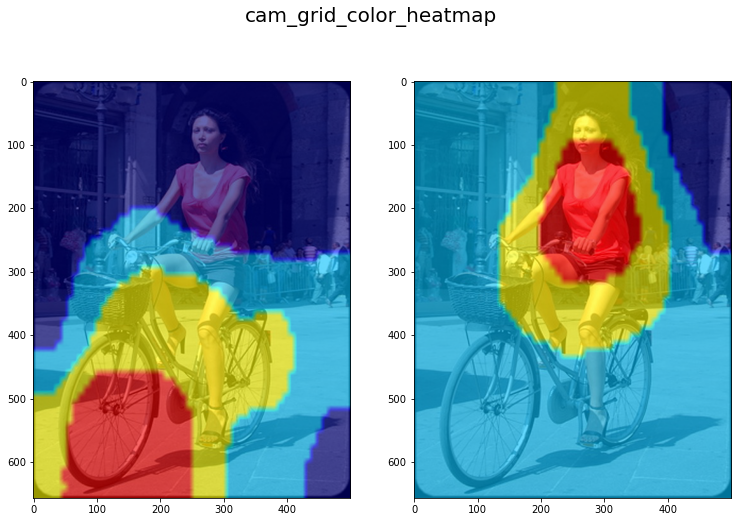

In [34]:
title = "cam_grid"
getHeatmap(CAM, height, width, title = title, figSet = True, fig = [1, len(classes)])

In [29]:
#makeSegment_ver1(0, FeatureMap, CAM)

27
22
(56, 56)
(56, 56)
(56, 56)
(56, 56)


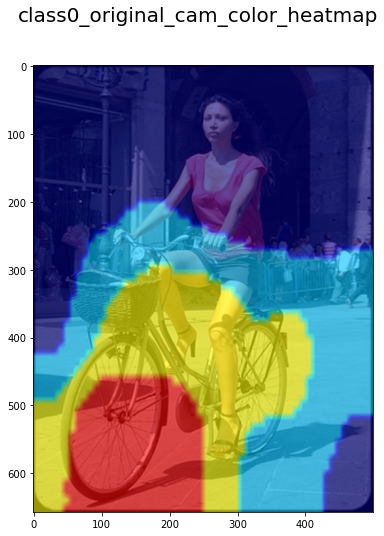

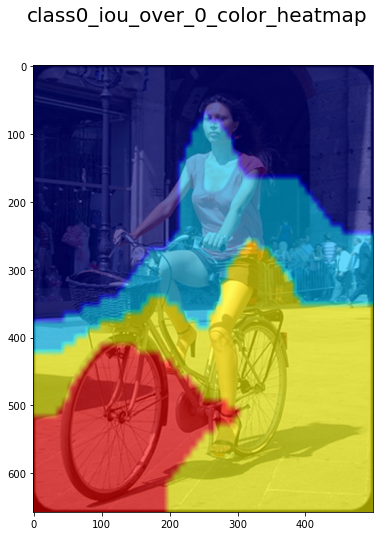

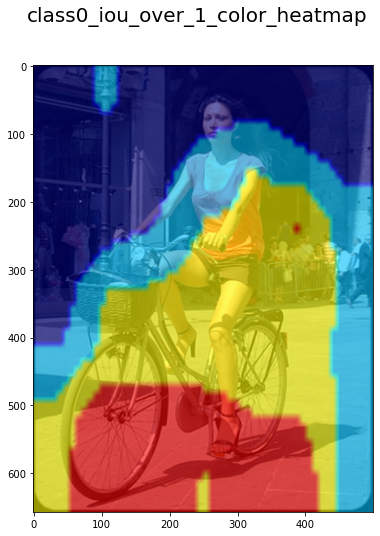

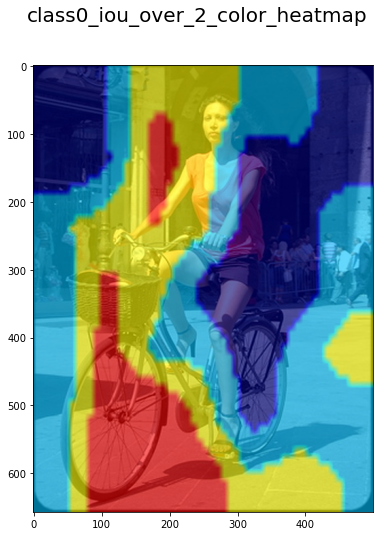

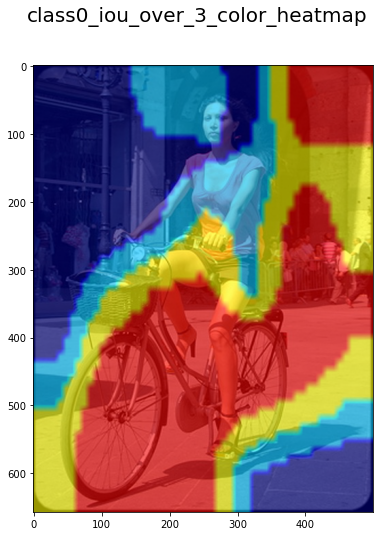

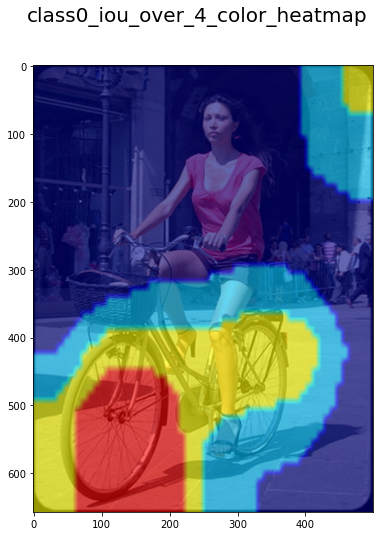

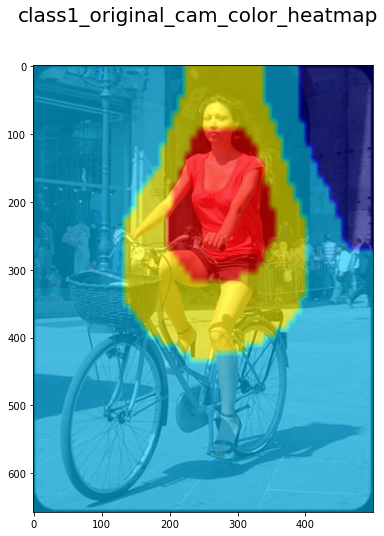

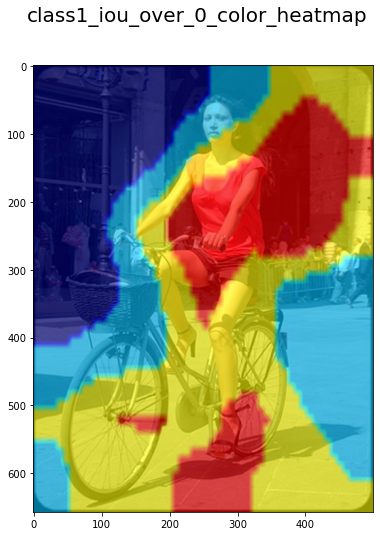

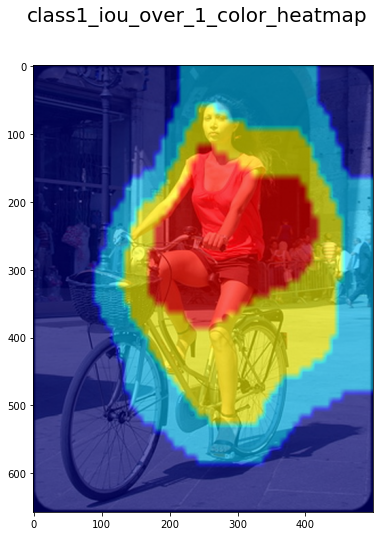

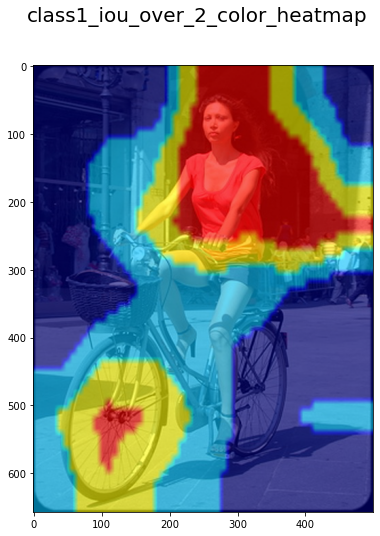

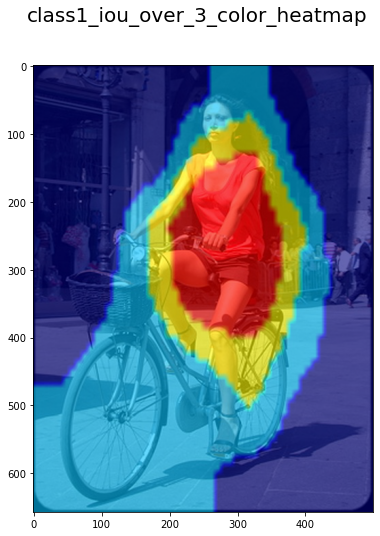

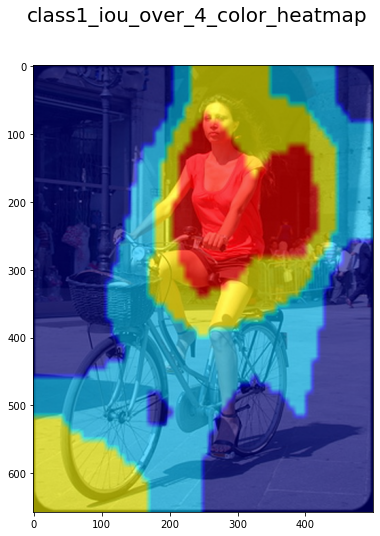

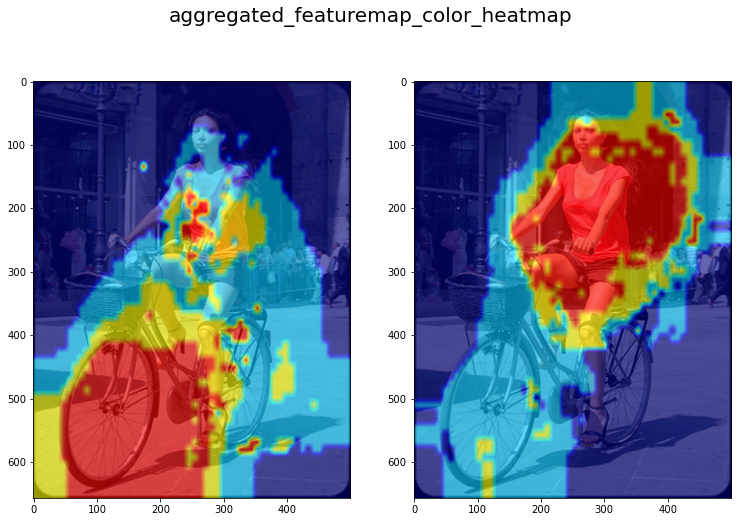

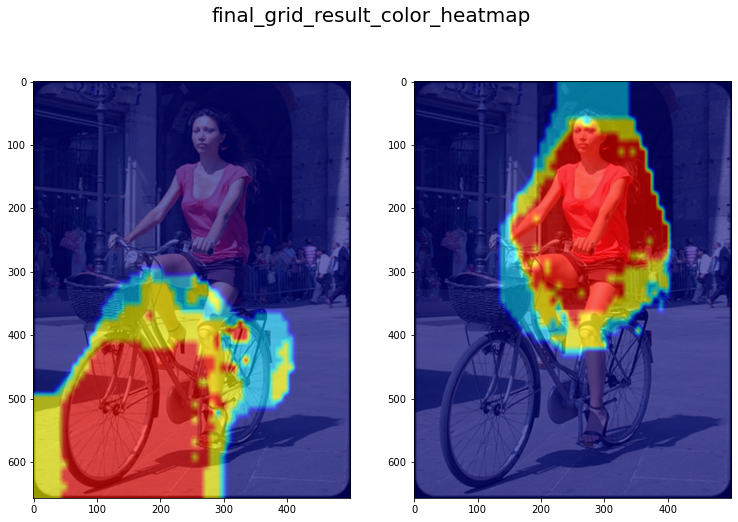

In [35]:
makeSegment_ver2(0, FeatureMap, CAM)